In [2]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM
from enum import IntEnum

t2img = T.ToPILImage()
img2t = T.ToTensor()

def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2
    
working_dir = "../data/"

In [3]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

print(f"CUDA: {torch.cuda.is_available()}")
print(f"MPS: {torch.mps.is_available()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.mps.is_available() else device

CUDA: True
MPS: False


In [5]:
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

In [6]:
class ToDevice(torch.nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self):
        return f"{self.__class__.__name__}(device={device})"

In [7]:
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self, root, split, target_types="segmentation", download=False, pre_transform=None,
        post_transform=None, pre_target_transform=None, post_target_transform=None, common_transform=None):
        
        super().__init__(root=root,split=split, target_types=target_types, download=download, transform=pre_transform, target_transform=pre_target_transform)
        
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        img, mask = super().__getitem__(idx)
        
        if self.common_transform:
            entry = self.common_transform(torch.cat([img, mask], dim=0))
            img, mask = torch.split(entry, 3, dim=0)
        
        if self.post_transform:
            img = self.post_transform(img)
            
        if self.post_target_transform:
            mask = self.post_target_transform(mask)

        return (img, mask)

In [9]:
pets_train = OxfordIIITPetsAugmented(
    root="../../data/OxfordPets/train/",
    split="trainval",
    target_types="segmentation",
    download=False,
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([ToDevice(get_device()), T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST), T.RandomHorizontalFlip(p=0.5)]),
    post_transform=T.ColorJitter(contrast=0.3),
    post_target_transform=T.Lambda(lambda x: (x * 255).to(torch.long) - 1),
)
pets_test = OxfordIIITPetsAugmented(
    root="../../data/OxfordPets/test//",
    split="test",
    target_types="segmentation",
    download=False,
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([ToDevice(get_device()), T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST), T.RandomHorizontalFlip(p=0.5)]),
    post_transform=T.ColorJitter(contrast=0.3),
    post_target_transform=T.Lambda(lambda x: (x * 255).to(torch.long) - 1)
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)

pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

In [11]:
for idx, _ in enumerate(pets_train_loader[:-1]):
    print(idx)

TypeError: 'DataLoader' object is not subscriptable

In [7]:
class BlockConv2d(nn.Module):
    def __init__(self, channels_in, channels_out, batch_size, kernel_size=3, stride=1, padding=0, dilation=1, bias=False):
        super(BlockConv2d, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(channels_in, channels_out, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias),
            nn.BatchNorm2d(batch_size),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer(x)


class DoubleConv2d(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size=3, stride=1, padding=0, dilation=1, bias=False):
        super(DoubleConv2d, self).__init__()
        self.layer = nn.Sequential(
            BlockConv2d(channels_in, channels_out, batch_size=channels_out, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias),
            BlockConv2d(channels_out, channels_out, batch_size=channels_out, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias)
        )

        self.maxpool = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        x = self.layer(x)
        shape = x.shape
        x, indices = self.maxpool(x)
        return x, indices, shape


class TripleConv2d(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size=3, stride=1, padding=0, dilation=1, bias=False):
        super(TripleConv2d, self).__init__()
        self.layer = nn.Sequential(
            BlockConv2d(channels_in, channels_out, batch_size=channels_out, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias),
            BlockConv2d(channels_out, channels_out, batch_size=channels_out, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias),
            BlockConv2d(channels_out, channels_out, batch_size=channels_out, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias)
        )

        self.maxpool = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        x = self.layer(x)
        shape = x.shape
        x, indices = self.maxpool(x)
        return x, indices, shape
        

class DoubleUnConv2d(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size=3, stride=1, padding=0, dilation=1, bias=False):
        super(DoubleUnConv2d, self).__init__()
        self.layer = nn.Sequential(
            BlockConv2d(channels_in, channels_in, batch_size=channels_in, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias),
            BlockConv2d(channels_in, channels_out, batch_size=channels_out, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias)
        )

        self.maxunpool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        x = self.maxunpool(x, indices, output_size=output_size)
        x = self.layer(x)
        return x
        
class TripleUnConv2d(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size=3, stride=1, padding=0, dilation=1, bias=False):
        super(TripleUnConv2d, self).__init__()
        self.layer = nn.Sequential(
            BlockConv2d(channels_in, channels_in, batch_size=channels_in, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias),
            BlockConv2d(channels_in, channels_in, batch_size=channels_in, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias),
            BlockConv2d(channels_in, channels_out, batch_size=channels_out, kernel_size=kernel_size, stride=1, padding=kernel_size//2, dilation=dilation, bias=bias)
        )

        self.maxunpool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, indices, output_size):
        x = self.maxunpool(x, indices, output_size=output_size)
        x = self.layer(x)
        return x


class ImageSegmentation(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.conv1 = DoubleConv2d(3, 64, kernel_size=kernel_size)
        self.conv2 = DoubleConv2d(64, 128, kernel_size=kernel_size)
        self.conv3 = TripleConv2d(128, 256, kernel_size=kernel_size)
        self.conv4 = TripleConv2d(256, 512, kernel_size=kernel_size)

        self.unconv1 = TripleUnConv2d(512, 256, kernel_size=kernel_size)
        self.unconv2 = TripleUnConv2d(256, 128, kernel_size=kernel_size)
        self.unconv3 = DoubleUnConv2d(128, 64, kernel_size=kernel_size)
        self.unconv4 = DoubleUnConv2d(64, 3, kernel_size=kernel_size)

        self.bn = nn.BatchNorm2d(3)

    def forward(self, x):
        x = self.bn(x)

        x, indices1, shape1 = self.conv1(x)
        x, indices2, shape2 = self.conv2(x)
        x, indices3, shape3 = self.conv3(x)
        x, indices4, shape4 = self.conv4(x)

        x = self.unconv1(x, indices4, shape4)
        x = self.unconv2(x, indices3, shape3)
        x = self.unconv3(x, indices2, shape2)
        x = self.unconv4(x, indices1, shape1)

        return x

In [8]:
def IoUMetric(pred, gt, softmax=False):
    if softmax:
        pred = nn.Softmax(dim=1)(pred)
        
    gt = torch.cat([(gt == i )for i in range(3)], dim=1)

    intersection = gt * pred
    union = gt + pred - intersection

    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    
    return iou.mean()

class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax
    
    def forward(self, pred, gt):
        return -(IoUMetric(pred, gt, self.softmax).log())

In [16]:
def train_model(model, loader, optimizer):
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss(reduction='mean')
    
    running_loss = 0.0
    running_samples = 0
    
    for idx, (img, mask) in enumerate(loader, 0):
        optimizer.zero_grad()
        img, mask = img.to(device), mask.to(device)
        
        outputs = model(img)
        
        mask = mask.squeeze(dim=1)
        
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()
    
        running_samples += mask.size(0)
        running_loss += loss.item()

    print(f"Trained {running_samples} samples, Loss: {(running_loss / (idx+1)):.4f}")

In [10]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()
    
def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    model.eval()
    model.to(device)
    
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels)
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    pred_labels = pred_labels.unsqueeze(1)
    pred_mask = pred_labels.to(torch.float)
    
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'

    while len(plt.get_fignums()) > 0:
        plt.close()
        
    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")
    
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    
    if show_plot is False:
        while len(plt.get_fignums()) > 0:
            plt.close()
    else:
        plt.show()

In [11]:
def test_dataset_accuracy(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    
    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []
    
    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)
        
        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        pred_labels = pred_labels.unsqueeze(1)
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())
        
        del inputs
        del targets
        del predictions
    
    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)
    
    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")

In [12]:
def train_loop(model, loader, test_data, epochs, optimizer, scheduler, save_path):
        test_inputs, test_targets = test_data
        epoch_i, epoch_j = epochs
        for i in range(epoch_i, epoch_j):
            epoch = i
            print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
            train_model(model, loader, optimizer)
            with torch.inference_mode():
                print_test_dataset_masks(model, test_inputs, test_targets, epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))
    
            if scheduler is not None:
                scheduler.step()
            print("")

In [13]:
m = ImageSegmentation(kernel_size=3)
m.to(device);

In [14]:
to_device(m)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

Epoch: 01, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.8988

Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7984


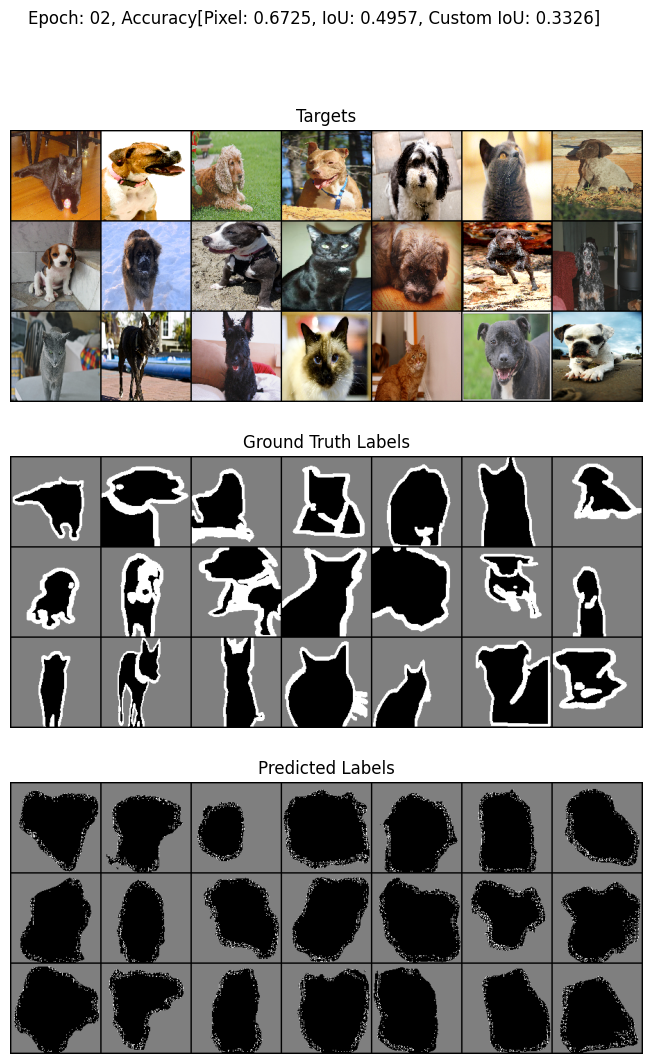

In [17]:
(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
train_loop(m, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, 3), optimizer, scheduler, save_path)

In [ ]:
import torch
import gc

def clear_cuda_memory():
    print("🔄 Running CUDA memory cleanup...")

    # Print memory usage before cleanup
    print(f"📌 Before cleanup: {torch.cuda.memory_allocated() / 1024**2:.2f} MB allocated")
    print(f"📌 Before cleanup: {torch.cuda.memory_reserved() / 1024**2:.2f} MB reserved")
    
    # Run garbage collection
    gc.collect()
    print("✅ Garbage collector executed.")
    
    # Empty PyTorch CUDA cache
    torch.cuda.empty_cache()
    print("✅ PyTorch CUDA cache cleared.")
    
    # Reset CUDA memory
    torch.cuda.ipc_collect()
    print("✅ IPC memory collected.")
    clear_cuda_memory()  # Run the cleanup function after deleting variables
    try:
        del m
    except:
        pass
    try:
        del model
    except:
        pass
    
    # Print memory usage after cleanup
    print(f"📌 After cleanup: {torch.cuda.memory_allocated() / 1024**2:.2f} MB allocated")
    print(f"📌 After cleanup: {torch.cuda.memory_reserved() / 1024**2:.2f} MB reserved")

    print("🚀 CUDA memory cleanup complete.")

# Run the function to clear memory
clear_cuda_memory()